In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
bs = 64

In [4]:
!ls /home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/

annotations  images


In [5]:
path = Path("/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images")

In [6]:
path.ls()

[PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/wheaten_terrier_27.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/British_Shorthair_90.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/english_cocker_spaniel_106.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/Birman_37.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/beagle_175.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/wheaten_terrier_53.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/miniature_pinscher_131.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/Persian_263.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/images/american_bulldog_180.jpg'),
 PosixPath('/home/ricky/Desktop/repos/fastai_course/da

## Data Augmentation

In [7]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4,
                     max_warp=0.4,
                     p_affine=1., p_lighting=1.)

In [8]:
doc(get_transforms)

In [9]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [10]:
def get_data(size, bs, padding_mode="reflection"):
    return (src.label_from_re(r"([^/]+)_\d+.jpg$")
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [11]:
data = get_data(224, bs, "zeros")

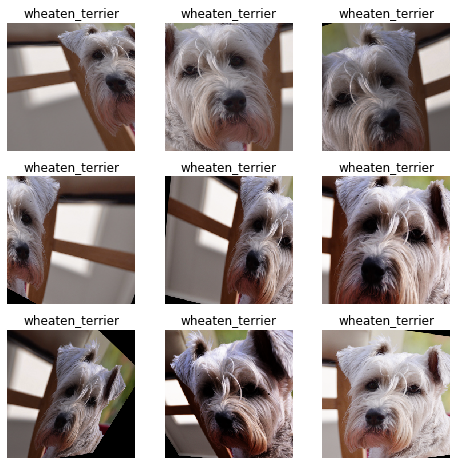

In [12]:
def _plot(i, j, ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8,8))

In [13]:
data = get_data(224, bs)

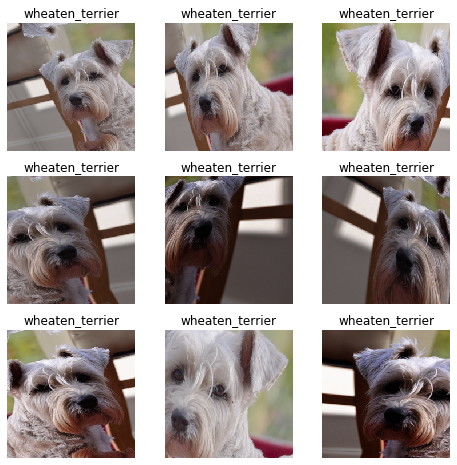

In [14]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [15]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [16]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.311361,1.086604,0.241543,00:33
1,1.366783,0.348065,0.092016,00:32
2,0.866912,0.269645,0.077131,00:33


In [17]:
learn.save('224-stage-1')

In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.684204,0.288038,0.068336,00:43
1,0.643448,0.281194,0.068336,00:43


In [19]:
learn.save('224-stage-2')

In [20]:
data = get_data(352, 32)
learn.data = data

In [21]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.753430,0.251411,0.055480,01:39
1,0.736423,0.259780,0.054804,01:38


In [22]:
learn.save('352')

## Convolution Kernel

In [24]:
data = get_data(352, 16)

In [25]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category pug

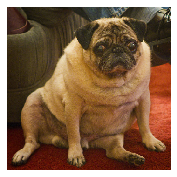

In [42]:
idx = 3
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [43]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [44]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [45]:
k.shape

torch.Size([1, 3, 3, 3])

In [46]:
t = data.valid_ds[3][0].data; t.shape

torch.Size([3, 352, 352])

In [49]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [47]:
edge = F.conv2d(t[None], k)

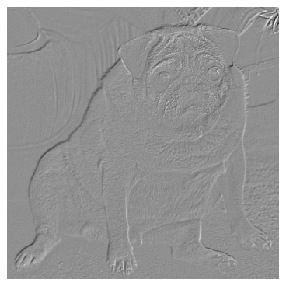

In [48]:
show_image(edge[0], figsize=(5,5))

In [50]:
data.c

37

In [51]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [52]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap 

In [53]:
m = learn.model.eval();

In [54]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [55]:
from fastai.callbacks.hooks import *

In [67]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [68]:
hook_a, hook_g = hooked_backward()

In [69]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [70]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [71]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
             interpolation='bilinear', cmap='magma')

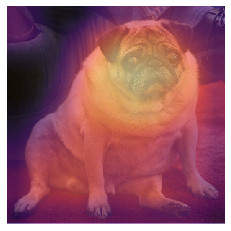

In [72]:
show_heatmap(avg_acts)